In [1]:
# IMU Test: FIGURE 4.2 and 4.3

# Lunar Leaper: Gravimetry Modelling
# Yara Luginbühl

# Input: ReadOut.py, FA_06_91_01_30_00.csv, VNYMR.csv
# Output: RawData.png, TempPlot.png

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ReadOut import read_bin_file

from datetime import timedelta, datetime
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from scipy import signal


from sklearn.linear_model import LinearRegression
from matplotlib.ticker import MaxNLocator

In [3]:

timestamps = pd.read_csv('Data/FA_06_91_01_30_00.csv')
#print(timestamps.columns)
data = pd.read_csv('Data/VNYMR.csv')
#print(data.columns)

print((np.diff(timestamps['TimeSyncIn'])/1e9) **(-1))
print((np.mean(np.diff(timestamps['TimeSyncIn'])/1e9) **(-1)))
print("Actual length:",len(timestamps), "Expected Length: 964320")
print("Delta_t:", (timestamps['TimeSyncIn'].iloc[-1] - timestamps['TimeSyncIn'].iloc[0])/1e9)
print("Delta_t [HH:MM:SS]", pd.to_timedelta((timestamps['TimeSyncIn'].iloc[-1] - timestamps['TimeSyncIn'].iloc[0])/1e9, unit='s'))
# I assume the total time (resulting in the expected length) is not correct (too short) resulting in more data points than expected.

[40.00160006 40.         40.         ... 39.99840006 40.
 40.        ]
40.000000000000064
Actual length: 964370 Expected Length: 964320
Delta_t: 24109.225
Delta_t [HH:MM:SS] 0 days 06:41:49.225000


In [4]:
def ms2_to_mg(ms2):
    return ms2 / 9.80665 * 1000 

def mg_to_ms2(mg):
    return mg * 9.80665 / 1000  

def seconds_to_hms(x, pos):
    hours = int(x // 3600)
    minutes = int((x % 3600) // 60)
    seconds = int(x % 60)
    return f'{hours:02}:{minutes:02}:{seconds:02}'

def ms2_to_mGal(ms2):
    return ms2 / 9.80665 * 1e6

def mGal_to_ms2(mg):
    return mg * 9.80665 / 1e6 


def filt_lp(y_full, freq_lowpass, fs=40.):
    Wn = freq_lowpass
    sos = signal.butter(N=8, Wn=Wn,
                        btype='lowpass',
                        output='sos',
                        fs=fs)
    return signal.sosfiltfilt(sos, y_full)


def detrend_linear(acc, temp):
    temp_reshaped = temp.reshape(-1, 1)
    model = LinearRegression()
    model.fit(temp_reshaped, acc)
    trend = model.predict(temp_reshaped)
    detrended = acc - trend
    return detrended, trend


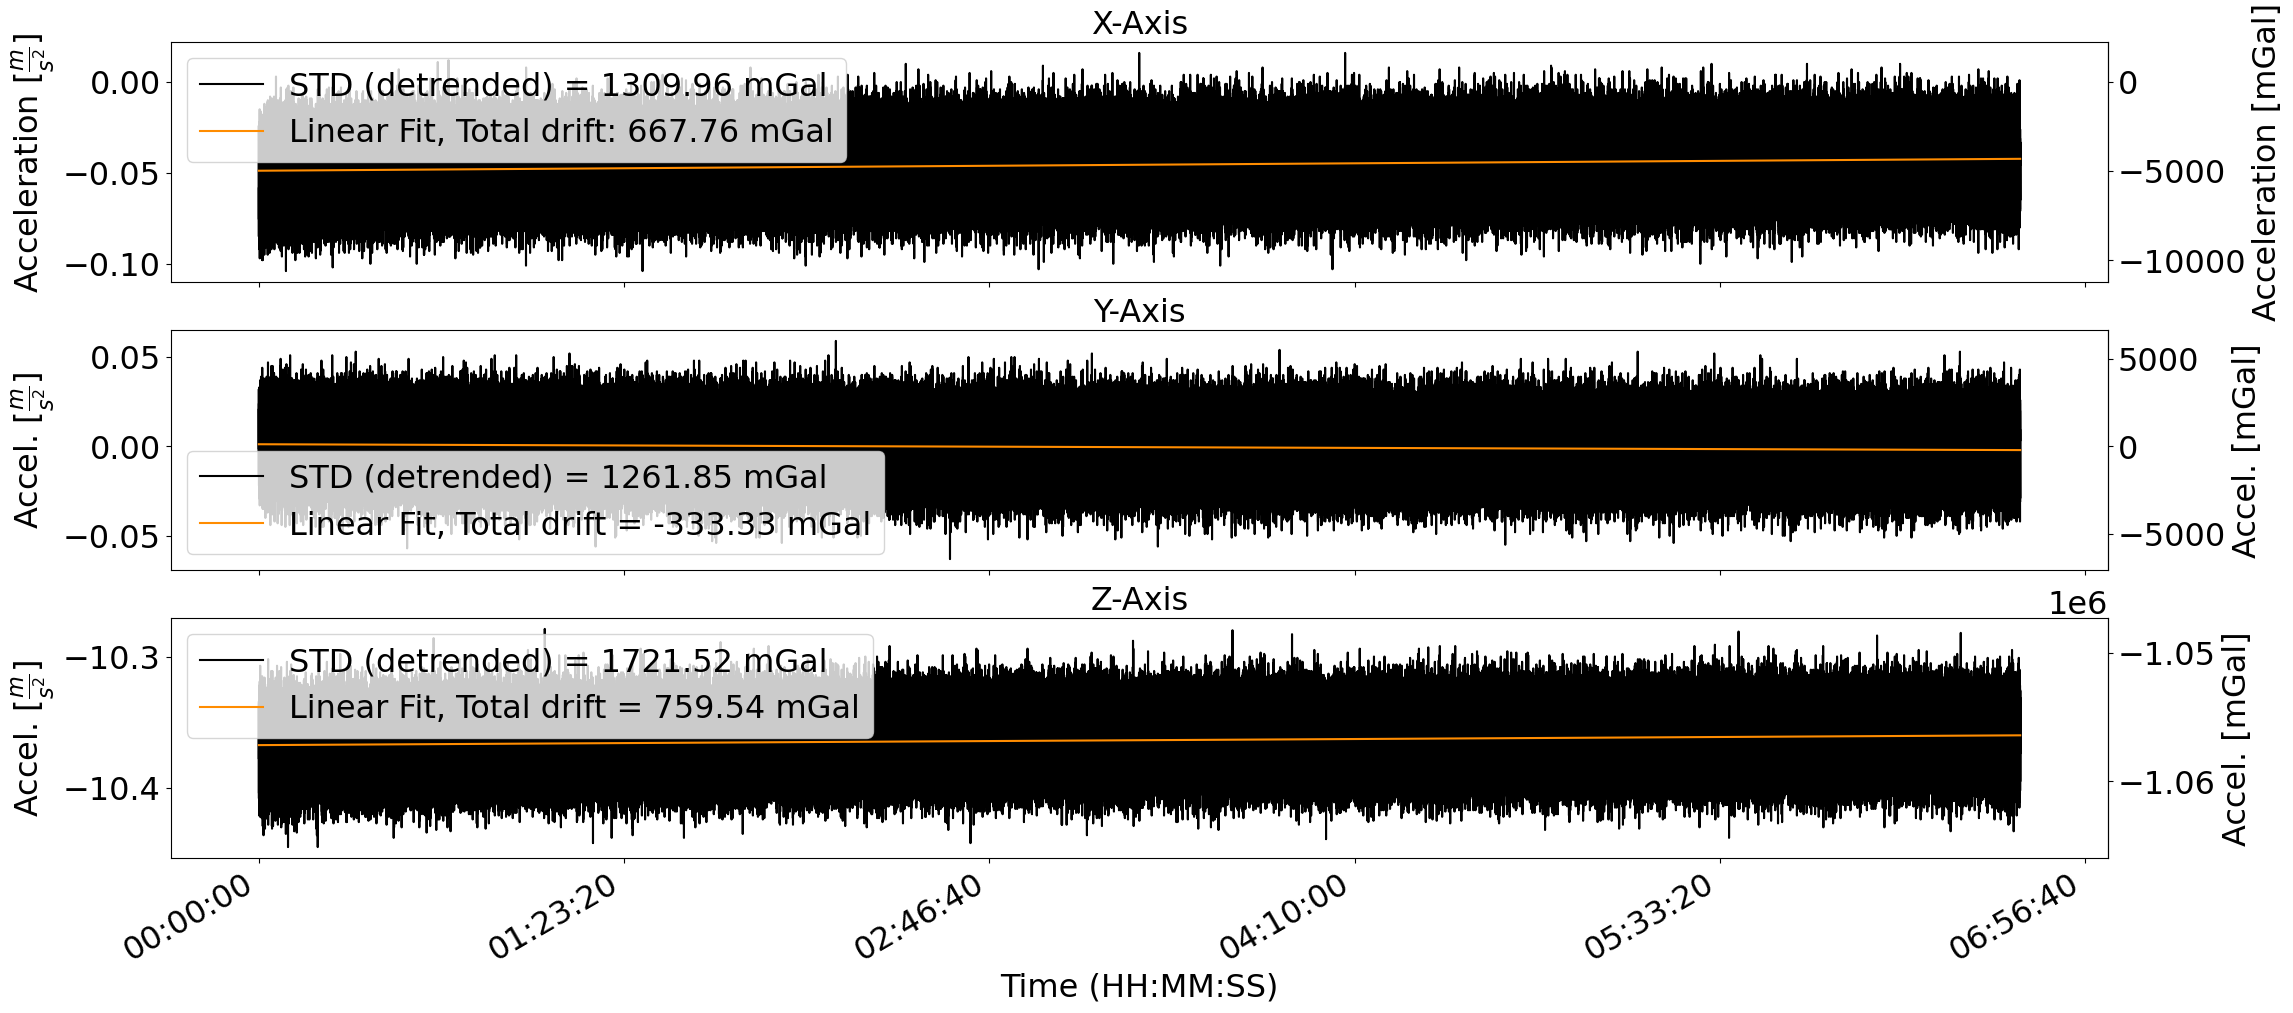

In [5]:

# PLOT TO SECOND TO LAST BECAUSE LENGTH OF ARRAY NOT THE SAME FOR WHATEVER REASON
plt.rcParams.update({
    "font.size": 23,            # base font size
    "axes.titlesize": 23,       # title font
    "axes.labelsize": 23,       # axis labels
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 23,
})

rel_time = timestamps['TimeSyncIn'] - timestamps['TimeSyncIn'].iloc[0]
time_s = rel_time / 1e9  # Convert to seconds

fig, ax = plt.subplots(3, 1, figsize=(25, 12), sharex=True)


a0, a1 = np.polyfit(time_s, data['AccelX'][:-1], 1)
linx =  a0*time_s + a1
std = ms2_to_mGal((data["AccelX"] - linx).std())

ax[0].plot(time_s, data['AccelX'][:-1], "k", label=f'STD (detrended) = {std:.2f} mGal', markersize=1)
ax[0].plot(time_s,linx, color = 'darkorange', label=f'Linear Fit, Total drift: {ms2_to_mGal(linx.iloc[-1]  - linx.iloc[0]):.2f} mGal')

ax[0].set_title("X-Axis")
ax[0].set_ylabel("Acceleration [$\\frac{m}{s^2}$]")
secax = ax[0].secondary_yaxis('right', functions=(ms2_to_mGal, mGal_to_ms2))
secax.set_ylabel('Acceleration [mGal]')
ax[0].legend()


#  Accel Y
a0, a1 = np.polyfit(time_s, data['AccelY'][:-1], 1)
liny = a0*time_s + a1
std = ms2_to_mGal((data["AccelY"] - liny).std())

ax[1].plot(time_s, data['AccelY'][:-1], "k", label=f'STD (detrended) = {std:.2f} mGal', markersize=1)
ax[1].plot(time_s,liny, color = 'darkorange', label=f'Linear Fit, Total drift = {ms2_to_mGal(liny.iloc[-1] - liny.iloc[0]):.2f} mGal')

ax[1].set_title("Y-Axis")
ax[1].set_ylabel("Accel. [$\\frac{m}{s^2}$]")
secax = ax[1].secondary_yaxis('right', functions=(ms2_to_mGal, mGal_to_ms2))
secax.set_ylabel('Accel. [mGal]')
ax[1].legend()

# Accel Z

a0, a1 = np.polyfit(time_s, data['AccelZ'][:-1], 1)
linz =  a0*time_s + a1
std = ms2_to_mGal((data["AccelZ"] - linz).std())

ax[2].plot(time_s, data['AccelZ'][:-1], "k", label=f'STD (detrended) = {std:.2f} mGal', markersize=1)
ax[2].plot(time_s, linz, color = 'darkorange', label=f'Linear Fit, Total drift = {ms2_to_mGal(linz.iloc[-1] - linz.iloc[0]):.2f} mGal')


ax[2].set_title("Z-Axis")
# ax[2].set_xlabel("Time [s]")
ax[2].set_ylabel("Accel. [$\\frac{m}{s^2}$]")
secax = ax[2].secondary_yaxis('right', functions=(ms2_to_mGal, mGal_to_ms2))
secax.set_ylabel('Accel. [mGal]')
ax[2].legend()

hms_formatter = FuncFormatter(seconds_to_hms)
ax[2].xaxis.set_major_formatter(hms_formatter)
fig.autofmt_xdate()
ax[2].set_xlabel("Time (HH:MM:SS)")

plt.savefig("Outputs/RawData.png")
plt.show()



1123.5 22985.725
1123.5 22985.725
1123.5 22985.725


C:\Users\yslug\AppData\Local\Temp\ipykernel_48204\1318409662.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


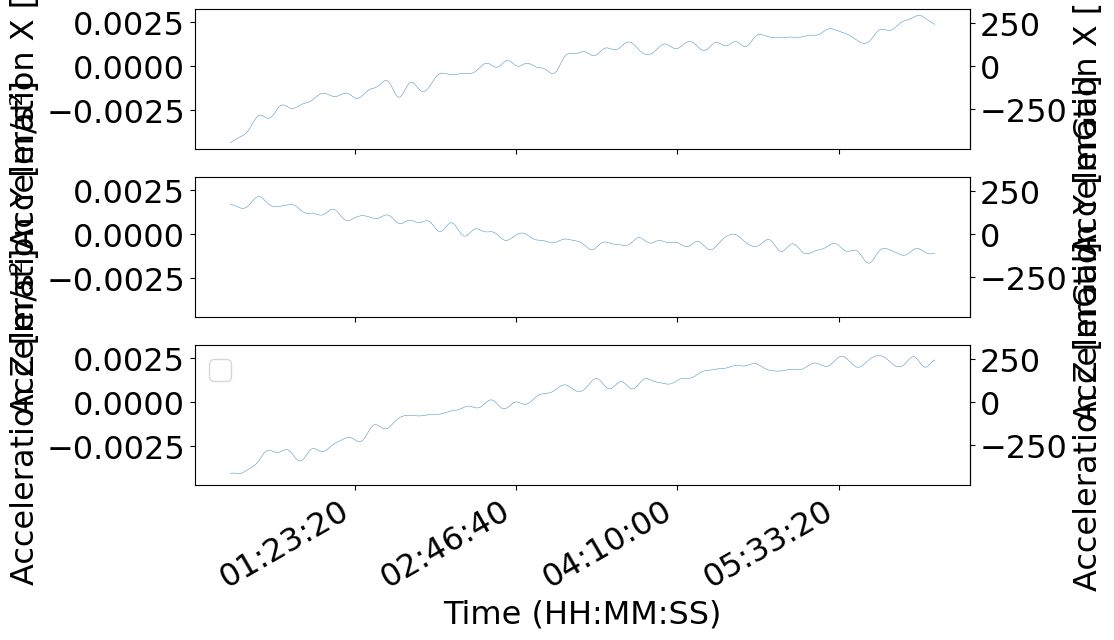

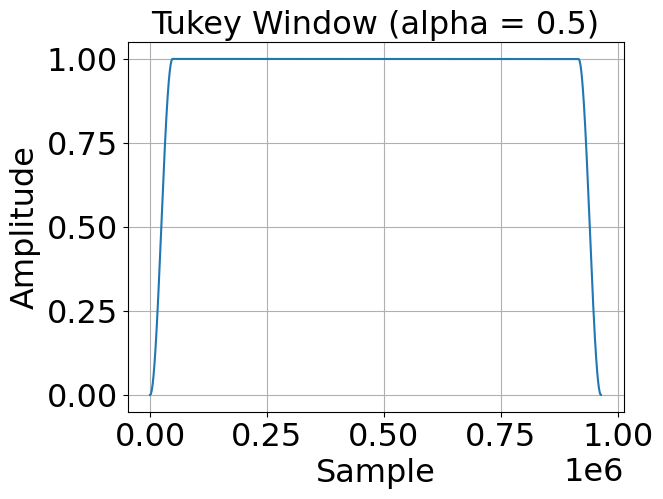

In [11]:


kind = 'Accel'
# LP filter period
period_lim = 600.
fs = 40

filtered_data = {}
valid_idx = {}
# Create joint plot
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 7), sharex='all', sharey='all')
for ax, comp in zip(axs, ['X', 'Y', 'Z']):
    chan = f'{kind}{comp}'
    
    values = data[chan][:-1] 
    N = len(values)
    len_sec = N / fs
    # Remove mean    
    data_demean = values - values.mean()

    # Taper data before filter application
    # taper = period_lim / len_sec * 4
    taper = period_lim/len_sec * 4
    window = signal.windows.tukey(M=len(data_demean), alpha=taper)
    data_taper =  window * data_demean

    # LP filter data
    data_filt = filt_lp(data_taper, 
                        freq_lowpass=1./period_lim,
                        fs=fs)

    idx = window > 0.99

    time = time_s[idx]
    print(time.min(), time.max())
    data_valid = data_filt[idx]
    valid_idx[comp] = idx

    filtered_data[comp] = data_valid
    
    # The idea was to get a proper time axis, but NumPy Datetime does not work like this :-(
    # time = time_s
    # ax.plot(time_s, data_demean)
    ax.plot(time, data_valid, lw=0.3)
    
    # ax.plot(time_s, data_filt - data_filt.mean(), lw=0.3)
    # ax.plot(time_s, window*0.01)
            #label=f'STD = {data_filt.std():.2f} m/s^2, mean: {data_filt.mean():.2f} m/s^2', markersize=1)
    ax.set_ylabel(f"Acceleration {comp} [m/s²]")
    
    secax = ax.secondary_yaxis('right', functions=(ms2_to_mGal, mGal_to_ms2))
    secax.set_ylabel(f'Acceleration {comp} [mGal]')
    
    # a0, a1 = np.polyfit(time, data_filt- data_filt.mean(), 1)
    # linx =  a0*time + a1
    #ax.plot(time, linx, 'r', label=f'Linear Fit: y = {a0:.2e}x + {a1:.2f}, total drift: {ms2_to_mg(linx[-1] - linx[0]):.2f} mg')

ax.xaxis.set_major_formatter(hms_formatter)
fig.autofmt_xdate()
ax.set_xlabel("Time (HH:MM:SS)")

#ax.set_ylim(-0.001, 0.001)
ax.legend()
plt.show()
plt.plot(window)
plt.title("Tukey Window (alpha = 0.5)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Pressure, Overnight_2705')

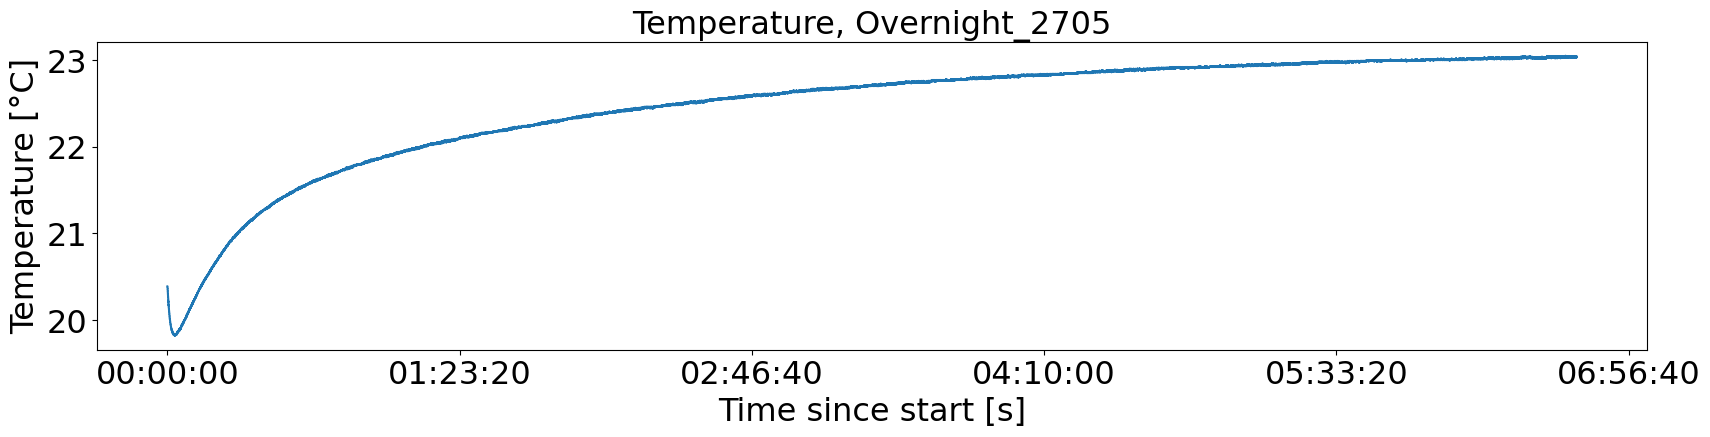

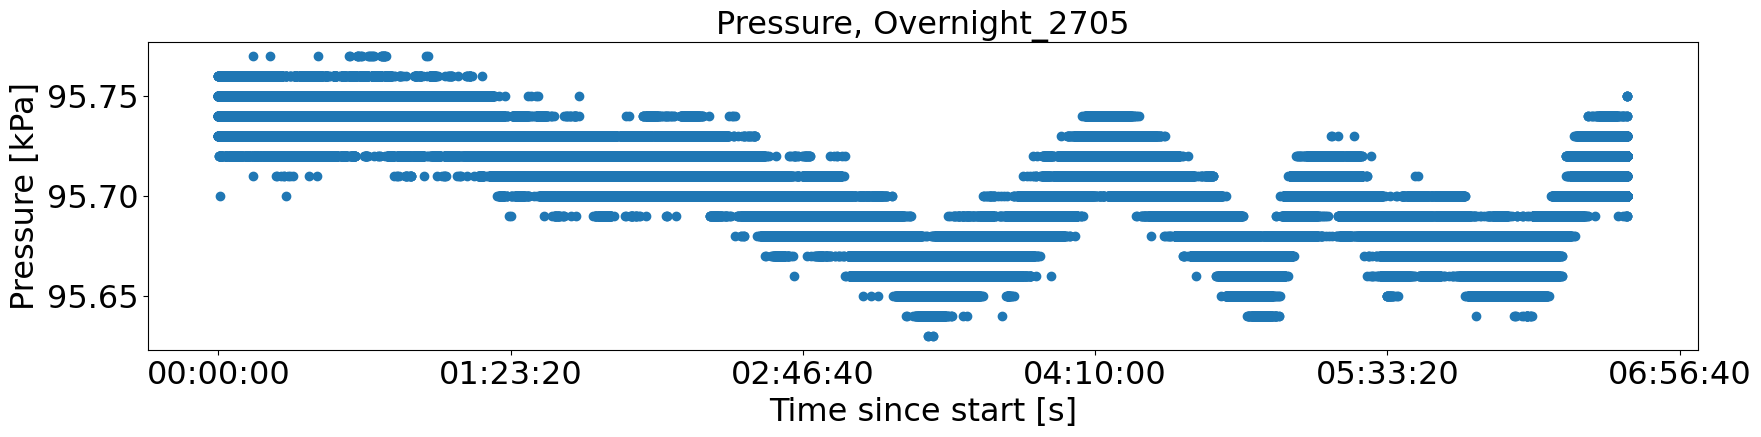

In [7]:
plt.figure(figsize = (20,4))
plt.plot(time_s, timestamps['Temperature'])
# I know this is a very stupid way to do it like this, i just wanted to quickly check how the temperature trend compares to the acceleration so i scaled the acceleration randomly:
# plt.plot(time, (data_filt - data_filt.mean())*900 + 21, lw=0.3, label = "z Accel")
plt.gca().xaxis.set_major_formatter(hms_formatter) 
plt.ylabel("Temperature [°C]")
plt.xlabel("Time since start [s]")
plt.title("Temperature, Overnight_2705")

plt.figure(figsize = (20,4))
plt.plot(time_s, timestamps['Pressure'], "o")
plt.gca().xaxis.set_major_formatter(hms_formatter) 
plt.ylabel("Pressure [kPa]")
plt.xlabel("Time since start [s]")
plt.title("Pressure, Overnight_2705")



Correlation between temperature and AccelX: 0.970
Correlation between temperature and AccelY: -0.945
Correlation between temperature and AccelZ: 0.974
Remaining Drift: 45.18170580436681
Remaining Drift: -20.738961872354075
Remaining Drift: 48.02778278188229


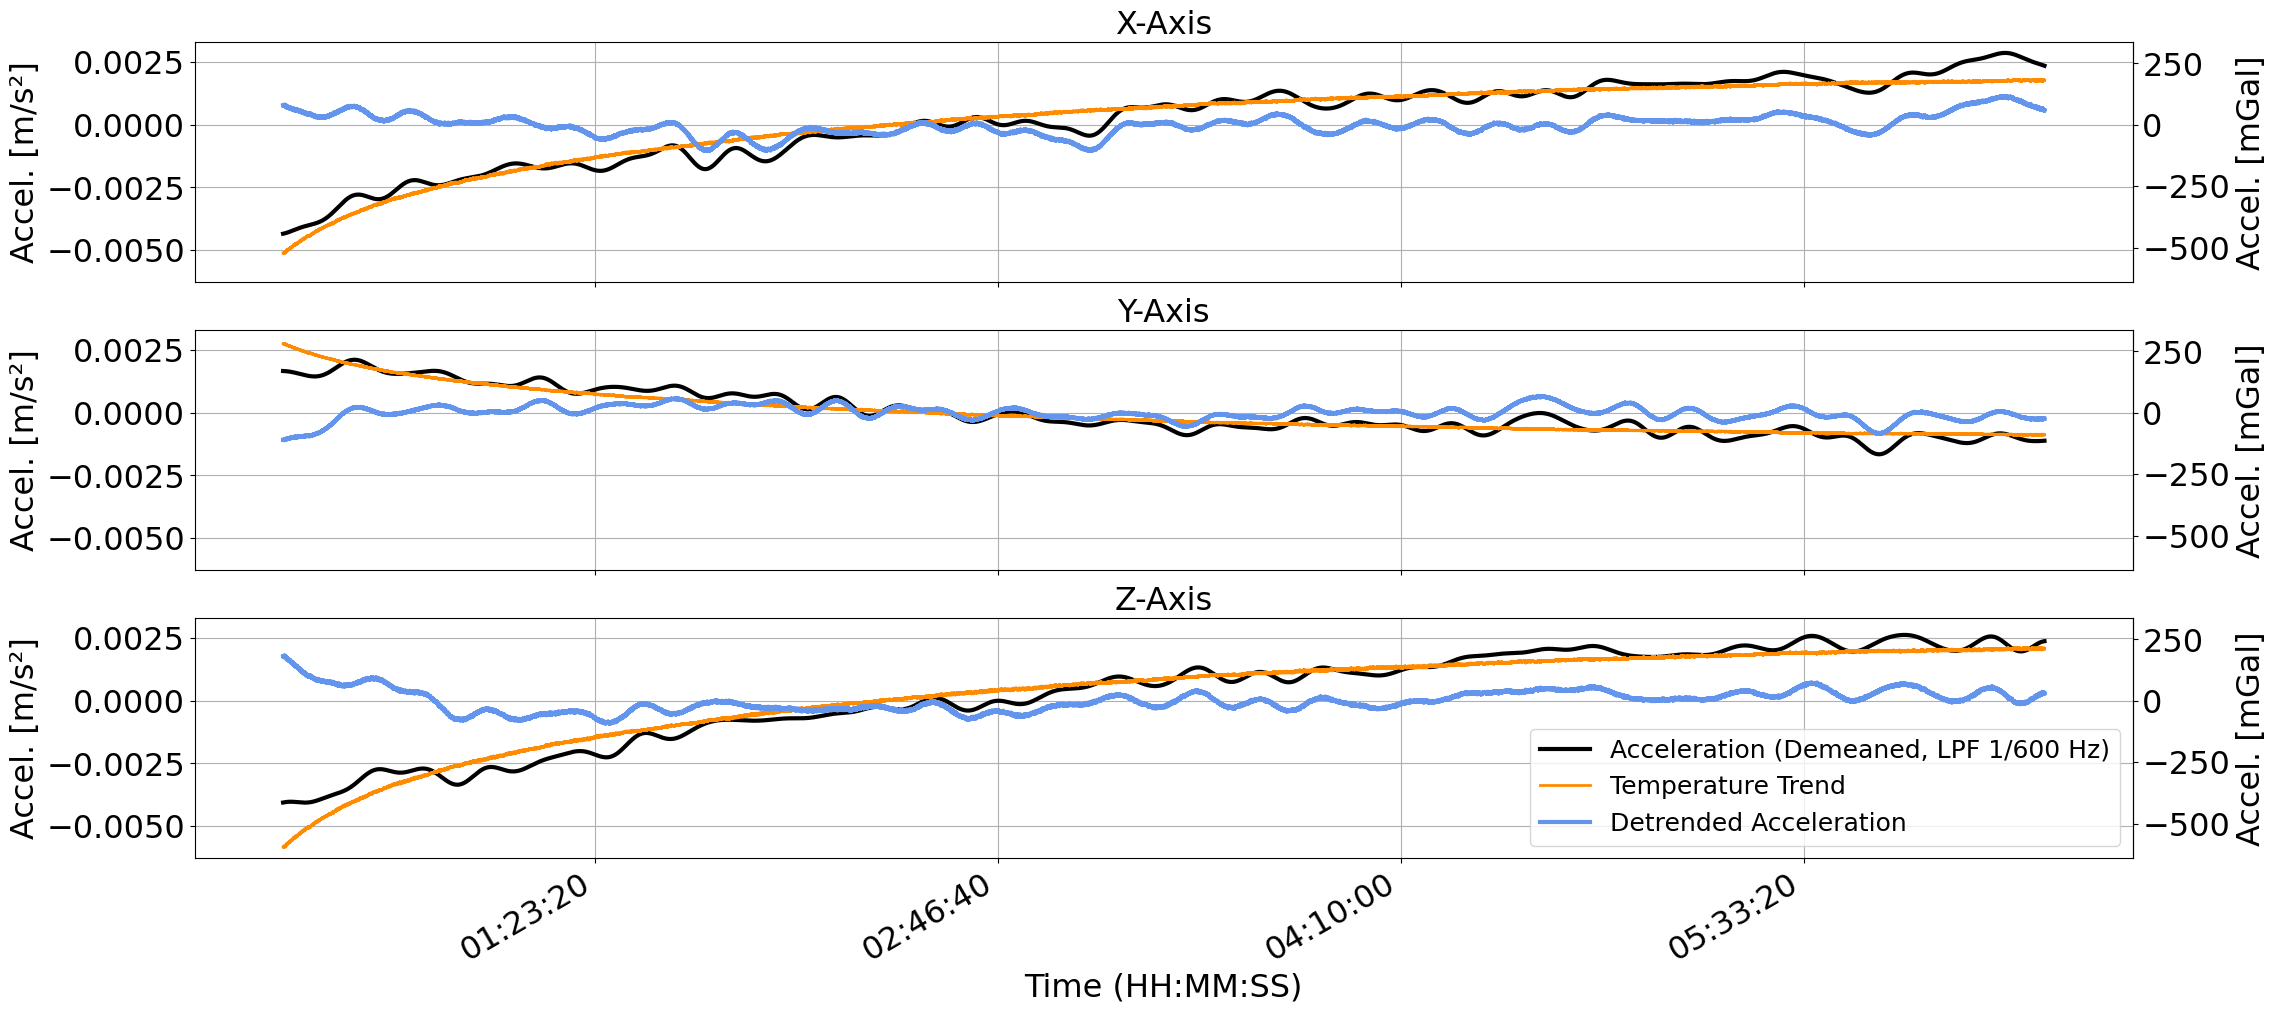

In [13]:
# DETRENDING FOR TEMP

temperature = timestamps['Temperature'].values
for comp in ['X', 'Y', 'Z']:
    acc = filtered_data[comp]
    temperature_new = temperature[valid_idx[comp]]
    r = np.corrcoef(acc, temperature_new)[0, 1]
    print(f'Correlation between temperature and Accel{comp}: {r:.3f}')


# PLOT TO SECOND TO LAST BECAUSE LENGTH OF ARRAY NOT THE SAME FOR WHATEVER REASON
plt.rcParams.update({
    "font.size": 23,            # base font size
    "axes.titlesize": 23,       # title font
    "axes.labelsize": 23,       # axis labels
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 18,
})

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(25, 12), sharex='all', sharey='all')
for ax, comp in zip(axs, ['X', 'Y', 'Z']):
    acc = filtered_data[comp]
    temp_reshaped = temperature_new.reshape(-1, 1)
    
    # Detrend the acceleration data
    acc_detrended, trend = detrend_linear(acc, temperature_new)
    
    # Plot the original and detrended data
    ax.plot(time, acc, label=f'Acceleration (Demeaned, LPF 1/600 Hz)', color = 'black', linewidth = 3)
    ax.plot(time, trend, label=f'Temperature Trend', color = 'darkorange', linewidth = 2)
    ax.plot(time, acc_detrended, label=f'Detrended Acceleration', color = 'cornflowerblue', linewidth = 3)
    
    ax.set_title(f"{comp}-Axis")
    ax.set_ylabel(f"Accel. [m/s²]")
    secax = ax.secondary_yaxis('right', functions=(ms2_to_mGal, mGal_to_ms2))
    secax.set_ylabel(f'Accel. [mGal]')
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4)) 
    secax.yaxis.set_major_locator(MaxNLocator(nbins=4)) 
    ax.grid()

    a0, a1 = np.polyfit(time, acc_detrended, 1)
    lin = a0*time_s + a1
    drift = ms2_to_mGal(lin.iloc[-1] - lin.iloc[0])
    print("Remaining Drift:", drift)



ax.legend()
ax.xaxis.set_major_formatter(hms_formatter)
fig.autofmt_xdate()
ax.set_xlabel("Time (HH:MM:SS)")

plt.savefig("Outputs/TempPlot.png")